In [75]:
import tensorflow as tf

from cifar_helper import get_data, chunks

import matplotlib.pyplot as plt
from sar_utilities import add_gaussian_noise
import numpy as np

In [76]:
test_imgs, test_classes = get_data('test_batch')
train_imgs1, train_classes1 = get_data('data_batch_1')
train_imgs2, train_classes2 = get_data('data_batch_2')
train_imgs3, train_classes3 = get_data('data_batch_3')
train_imgs4, train_classes4 = get_data('data_batch_4')
train_imgs5, train_classes5 = get_data('data_batch_5')

train_imgs = np.concatenate((train_imgs1, train_imgs2, train_imgs3, train_imgs4, train_imgs5))

train_classes = np.concatenate((train_classes1, train_classes2, train_classes3, train_classes4, train_classes5))
print(train_imgs.shape)
print(train_classes.shape)

Loading data: /scratch/hle/cifar-10-batches-py/test_batch
Loading data: /scratch/hle/cifar-10-batches-py/data_batch_1
Loading data: /scratch/hle/cifar-10-batches-py/data_batch_2
Loading data: /scratch/hle/cifar-10-batches-py/data_batch_3
Loading data: /scratch/hle/cifar-10-batches-py/data_batch_4
Loading data: /scratch/hle/cifar-10-batches-py/data_batch_5
(50000, 32, 32, 3)
(50000,)


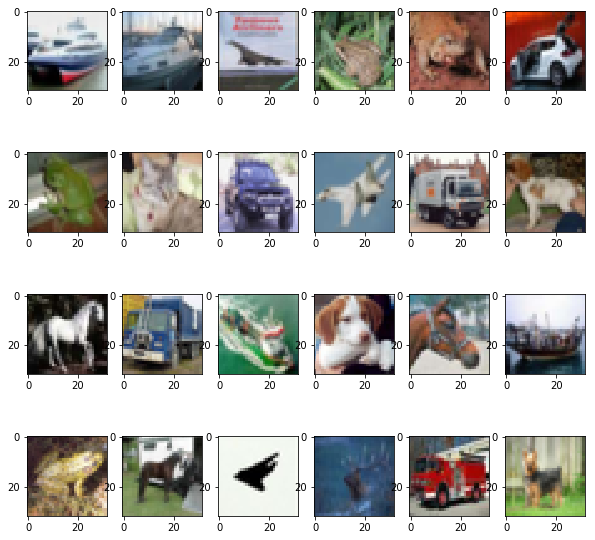

In [77]:
fig=plt.figure(figsize=(10, 10))
columns = 6
rows = 4
i = 1
while i < 25:
    image = test_imgs[i]
    img_copy = image.copy()
    img_copy = add_gaussian_noise(img_copy, sd=0.1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    i+=1


In [78]:
def one_hot_encoding(labels):
    encoded_labels = []
    for label in labels:
        encoded_label = np.zeros(10)
        encoded_label[label] = 1
        encoded_labels.append(encoded_label)
    return np.array(encoded_labels)

In [79]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')




def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out

In [86]:
epochs = 100
batch_size = 128
keep_probability = 0.7
learning_rate = 0.1

In [81]:
logits = conv_net(x, keep_prob)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [82]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
})
    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
#     valid_acc = sess.run(accuracy, 
#                          feed_dict={
#                              x: valid_features,
#                              y: valid_labels,
#                              keep_prob: 1.
#                          })
    
#     print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    print('Loss: {:>10.4f}'.format(loss))

In [87]:
image_batches = np.array(list(chunks(train_imgs, batch_size)))
label_batches = np.array(list(chunks(train_classes, batch_size)))

trained_model_path = '/scratch/hle/data/trained_models/'
saver = tf.train.Saver(max_to_keep=20)

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    i = 0
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for j in range(1,5):
            batch_features = image_batches[i]
            batch_labels = one_hot_encoding(label_batches[i])
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            i+=1      
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, j), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
        if (epoch % 5 == 0):
            save_path = saver.save(sess, trained_model_path + ('%s/'% 'cifar_classifier/') +\
                                   "cifar_classifier_model_%s.ckpt" %  str(epoch+1))
            print("Model saved in file: %s" % save_path)

Epoch  1, CIFAR-10 Batch 1:  Loss:   226.3045
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.6266
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.3589
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.5539
Model saved in file: /scratch/hle/data/trained_models/cifar_classifier//cifar_classifier_model_1.ckpt
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.8464
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.6684
Epoch  2, CIFAR-10 Batch 3:  Loss:     3.6514
Epoch  2, CIFAR-10 Batch 4:  Loss:     3.1679
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.4001
Epoch  3, CIFAR-10 Batch 2:  Loss:     2.5206
Epoch  3, CIFAR-10 Batch 3:  Loss:     2.5093
Epoch  3, CIFAR-10 Batch 4:  Loss:     2.5000
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.4091
Epoch  4, CIFAR-10 Batch 2:  Loss:     2.3686
Epoch  4, CIFAR-10 Batch 3:  Loss:     2.3230
Epoch  4, CIFAR-10 Batch 4:  Loss:     2.3532
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.3642
Epoch  5, CIFAR-10 Batch 2:  Loss:     2.2936
Epoch  5, CIFAR-10 Batch 3:  Loss:     2.3533
Epoch  5, CIFAR-10 Batch

KeyboardInterrupt: 

In [74]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

logits = conv_net(x, keep_prob)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
saver = tf.train.Saver()

model_path_test = '/scratch/hle/data/trained_models/cifar_classifier/cifar_classifier_model_96.ckpt'
image_batches = np.array(list(chunks(test_imgs, 100)))
label_batches = np.array(list(chunks(test_classes, 100)))
with tf.Session() as sess:
    saver.restore(sess, model_path_test)

    test_batch = image_batches[0]
    test_label = one_hot_encoding(label_batches[0])

    acc = sess.run(accuracy, feed_dict={x: test_batch,
                             y: test_label,
                             keep_prob: 1.})
    print(acc)

INFO:tensorflow:Restoring parameters from /scratch/hle/data/trained_models/cifar_classifier/cifar_classifier_model_96.ckpt
0.29


In [88]:
import keras

ImportError: No module named 'keras'